In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import random
from pathlib import Path
from torchvision.transforms import ToTensor
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import torchvision.datasets as datasets
from torchvision import models
from sklearn.model_selection import train_test_split

In [2]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# pixel_stats = pd.read_csv('../input/recursion-cellular-image-classification/pixel_stats.csv')

In [4]:
# pixel_stats.head()

In [5]:
def get_img_path(suffix, experiment, plate, well, site=1):
    return suffix + experiment.lower() + '/' + 'plate' + str(plate) + '/' + well + '_s{}.npy'.format(site)

In [6]:
# tr_df = pd.read_csv('../input/recursion-cellular-image-classification/train_controls.csv')
tr_df = pd.read_csv('../input/recursion-cellular-image-classification/train.csv')
tr_df = tr_df.append(pd.read_csv('../input/recursion-cellular-image-classification/train_controls.csv'), ignore_index=True, sort=False)
tr_df['site'] = 1
tr_df_copy = tr_df.copy()
tr_df_copy['site'] = 2
tr_df = tr_df.append(tr_df_copy, ignore_index=True)
tr_df['cellline'] = tr_df.apply(lambda row : row.experiment[:-3], axis=1)
tr_df['exp_plate'] = tr_df.apply(lambda row: row.experiment + '_' + str(row.plate), axis=1)
tr_df['path'] = tr_df.apply(lambda row : get_img_path('recursion-npy-train-', row.experiment, row.plate, row.well, row.site), axis=1)

In [7]:
te_controls = pd.read_csv('../input/recursion-cellular-image-classification/test_controls.csv')
te_controls['site'] = 1
te_controls_copy = te_controls.copy()
te_controls_copy['site'] = 2
te_controls = te_controls.append(te_controls_copy, ignore_index=True)
te_controls['cellline'] = te_controls.apply(lambda row : row.experiment[:-3], axis=1)
te_controls['exp_plate'] = te_controls.apply(lambda row: row.experiment + '_' + str(row.plate), axis=1)
te_controls['path'] = te_controls.apply(lambda row : get_img_path('recursion-npy-test-', row.experiment, row.plate, row.well, row.site), axis=1)

In [8]:
tr_df = tr_df.append(te_controls, ignore_index=True, sort=False)

In [9]:
experiments = list(tr_df['experiment'].unique())

In [10]:
len(experiments)

51

In [11]:
# va_exps = ['HUVEC-01', 'HEPG2-01', 'RPE-01', 'U2OS-01']

In [12]:
# tr_df['is_valid'] = tr_df.experiment.str.contains('|'.join(va_exps))

In [13]:
# va_df = tr_df[tr_df['is_valid']]
# tr_df = tr_df[~tr_df['is_valid']]

In [14]:
tr_df, va_df = train_test_split(tr_df, random_state=42, stratify=tr_df.sirna)

In [15]:
len(va_df), len(tr_df)

(21429, 64287)

In [16]:
# te_df = pd.read_csv('../input/recursion-cellular-image-classification/test_controls.csv')
# # te_df = pd.read_csv('../input/recursion-cellular-image-classification/test.csv')
# # te_df = te_df.append(pd.read_csv('../input/recursion-cellular-image-classification/test_controls.csv'), ignore_index=True, sort=False)
# te_df['site'] = 1
# te_df['cellline'] = te_df.apply(lambda row : row.experiment[:-3], axis=1)
# te_df = te_df[te_df['cellline'] == 'HUVEC']
# te_df['path'] = te_df.apply(lambda row : get_img_path('recursion-npy-test-', row.experiment, row.plate, row.well, row.site), axis=1)
# te_df1 = te_df

In [17]:
# te_df = pd.read_csv('../input/recursion-cellular-image-classification/test_controls.csv')
# # te_df = pd.read_csv('../input/recursion-cellular-image-classification/test.csv')
# # te_df = te_df.append(pd.read_csv('../input/recursion-cellular-image-classification/test_controls.csv'), ignore_index=True, sort=False)
# te_df['site'] = 2
# te_df['cellline'] = te_df.apply(lambda row : row.experiment[:-3], axis=1)
# te_df = te_df[te_df['cellline'] == 'HUVEC']
# te_df['path'] = te_df.apply(lambda row : get_img_path('recursion-npy-test-', row.experiment, row.plate, row.well, row.site), axis=1)
# te_df2 = te_df

In [18]:
exp_plate_to_index = dict((ep,i) for i,ep in enumerate(tr_df['exp_plate'].unique()))

In [19]:
celllines_to_index = {'HUVEC': 0, 'HEPG2': 1, 'RPE': 2, 'U2OS': 3}

In [20]:
well_to_index = dict((ep,i) for i,ep in enumerate(tr_df['well'].unique()))

In [21]:
class RecursionDataset(Dataset):
    def __init__(self, path, df, augment=False, img_size=512):
        self.df = df
        self.len = len(df)
        self.path = path
        if 'sirna' in df.columns:
            self.labels = list(df['sirna'])
        else:
            self.labels = list(df['id_code'])
        self.plates = list(map(lambda ep: exp_plate_to_index[ep], list(df['exp_plate'])))
        self.celllines = list(map(lambda c: celllines_to_index[c], list(df['cellline'])))
        self.wells = list(map(lambda c: well_to_index[c], list(df['well'])))
        self.img_paths = list(df['path'])
        self.totensor = ToTensor()
        self.augment = augment
        self.img_size = img_size
        
    def __getitem__(self, index):
        label = self.labels[index]
        path = self.path/self.img_paths[index]
        img = np.load(path)
#         img = img / 255.0
        img = img.astype(np.float32)
        if self.augment:
            # random crop a img_size by img_size patch
            row_start = random.randint(0, img.shape[0] - self.img_size)
            col_start = random.randint(0, img.shape[1] - self.img_size)
        else:
            row_start = int(0.5 * (img.shape[0] - self.img_size))
            col_start = int(0.5 * (img.shape[1] - self.img_size))
        img = img[row_start:row_start+self.img_size,col_start:col_start+self.img_size,:]
        if self.augment:
            # flip vert with p=0.5
            if random.random() < 0.5:
                img = img[:,::-1,:]
            # flip hori with p=0.5
            if random.random() < 0.5:
                img = img[::-1,:,:]
            img = img.copy()
        img = self.totensor(img)
        return img, label, self.plates[index], self.celllines[index], self.wells[index]
    
    def __len__(self):
        return self.len

In [22]:
bs = 512
nw = 4
img_size = 32

In [23]:
tr_ds = RecursionDataset(Path('../input'), tr_df, augment=True, img_size=img_size)
va_ds = RecursionDataset(Path('../input'), va_df, img_size=img_size)
# te_ds1 = RecursionDataset(Path('../input'), te_df1)
# te_ds2 = RecursionDataset(Path('../input'), te_df2)

In [24]:
tr_dl = DataLoader(tr_ds, batch_size=bs, num_workers=nw, pin_memory=True, shuffle=True, drop_last=False)
va_dl = DataLoader(va_ds, batch_size=bs, num_workers=2, pin_memory=True, shuffle=False)
# te_dl1 = DataLoader(te_ds1, batch_size=bs, num_workers=nw, pin_memory=True, shuffle=False)
# te_dl2 = DataLoader(te_ds2, batch_size=bs, num_workers=nw, pin_memory=True, shuffle=False)

In [25]:
len(tr_ds), len(va_ds)

(64287, 21429)

In [26]:
len(tr_df.sirna.unique())

1139

In [27]:
len(tr_df.exp_plate.unique())

204

In [28]:
num_sirnas = len(tr_df.sirna.unique())

In [29]:
num_plates = len(tr_df.exp_plate.unique())

In [30]:
num_celllines = len(tr_df.cellline.unique())

In [31]:
num_wells = len(tr_df.well.unique())

In [32]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [33]:
# # Linear classifier
# model = nn.Sequential(
#     nn.AvgPool2d(kernel_size=4),
#     Flatten(),
#     nn.Linear(in_features=128 * 128 * 6,
#              out_features=num_classes)
# ).cuda()

In [34]:
# # Smaller version of Lenet
# model = nn.Sequential(
#     nn.AvgPool2d(kernel_size=16),
#     nn.Conv2d(in_channels=6,
#              out_channels=12,
#              kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(in_channels=12,
#              out_channels=24,
#              kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     Flatten(),
#     nn.Linear(in_features=24 * 5 * 5,
#              out_features=num_classes)
# ).cuda()

In [35]:
# # Lenet-5
# # From https://engmrk.com/lenet-5-a-classic-cnn-architecture/
# model = nn.Sequential(
# #     nn.AvgPool2d(kernel_size=16),
#     nn.Conv2d(in_channels=6,
#              out_channels=6,
#              kernel_size=5),
#     nn.ReLU(),
#     nn.AvgPool2d(kernel_size=2),
#     nn.Conv2d(in_channels=6,
#              out_channels=16,
#              kernel_size=5),
#     nn.ReLU(),
# #     nn.AvgPool2d(kernel_size=2),
#     Flatten(),
#     nn.Linear(in_features=1600,
#              out_features=120),
#     nn.ReLU(),
#     nn.Linear(in_features=120,
#              out_features=84),
#     nn.ReLU(),
#     nn.Linear(in_features=84,
#              out_features=num_classes)
# ).cuda()

In [36]:
# # vgg like for 512x512
# # From https://neurohive.io/en/popular-networks/vgg16/
# model = nn.Sequential(
# #     nn.AvgPool2d(kernel_size=2),
#     nn.Sequential(
#         nn.Conv2d(in_channels=6,
#                  out_channels=16,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=16,
#                  out_channels=16,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#     ),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Sequential(
#         nn.Conv2d(in_channels=16,
#                  out_channels=32,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=32,
#                  out_channels=32,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#     ),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Sequential(
#         nn.Conv2d(in_channels=32,
#                  out_channels=64,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=64,
#                  out_channels=64,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#     ),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Sequential(
#         nn.Conv2d(in_channels=64,
#                  out_channels=128,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=128,
#                  out_channels=128,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#     ),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Sequential(
#         nn.Conv2d(in_channels=128,
#                  out_channels=256,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=256,
#                  out_channels=256,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#     ),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Sequential(
#         nn.Conv2d(in_channels=256,
#                  out_channels=512,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=512,
#                  out_channels=512,
#                  kernel_size=3,
#                  padding=1),
#         nn.ReLU(),
#     ),
#     nn.MaxPool2d(kernel_size=2),
#     Flatten(),
#     nn.Sequential(
#         nn.Linear(in_features=512 * 8 * 8,
#                  out_features=num_classes),
#     )
# ).cuda()

In [37]:
# model = models.vgg16_bn(num_classes=num_classes)
# model.features[0] = nn.Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# model = model.cuda()

In [38]:
# model = models.vgg16_bn(pretrained=True)
# w = model.features[0].weight.mean(dim=1, keepdim=True)
# b = model.features[0].bias
# model.features[0] = nn.Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# with torch.no_grad():
#     model.features[0].weight *= 0.0
#     model.features[0].weight += w
#     model.features[0].bias = b
# for param in model.features:
#     param.requires_grad = False
# model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
# model.features[0].requires_grad = True
# model.classifier.requires_grad = True
# model = model.cuda()

In [39]:
# features = models.densenet201(pretrained=True).features
# w = features.conv0.weight.mean(dim=1, keepdim=True)
# features.conv0 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# with torch.no_grad():
#     features.conv0.weight *= 0.0
#     features.conv0.weight += w
# features = features.cuda()

In [40]:
# classifier = nn.Sequential(
#     nn.AdaptiveAvgPool2d(output_size=1),
#     nn.Flatten(),
#     nn.BatchNorm1d(1920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=1920, out_features=512),
#     nn.ReLU(inplace=True),
#     nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=512, out_features=num_classes),
# )
# classifier = classifier.cuda()

In [41]:
# domain_classifier = nn.Sequential(
#     nn.AdaptiveAvgPool2d(output_size=1),
#     nn.Flatten(),
#     nn.BatchNorm1d(1920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=1920, out_features=512),
#     nn.ReLU(inplace=True),
#     nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=512, out_features=num_domains),
# )
# domain_classifier = domain_classifier.cuda()

In [42]:
features = models.resnet18(pretrained=True)
w = features.conv1.weight.mean(dim=1, keepdim=True)
features.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
with torch.no_grad():
    features.conv1.weight *= 0.0
    features.conv1.weight += w
features.fc = nn.Identity()
features = features.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


In [43]:
def make_classifier(num_outputs, num_inputs):
    classifier = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(num_inputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=num_inputs, out_features=128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=128, out_features=num_outputs),
    )
    classifier = classifier.cuda()
    return classifier

In [44]:
feature_dim = 512

In [45]:
sirna_classifier = make_classifier(num_sirnas, feature_dim)
plate_classifier = make_classifier(num_plates, feature_dim)
cellline_classifier = make_classifier(num_celllines, feature_dim)
well_classifier = make_classifier(num_wells, feature_dim)

In [46]:
model = nn.ModuleDict({'features': features, 'sirna': sirna_classifier, 'plate': plate_classifier, 'cellline': cellline_classifier, 'well': well_classifier})

In [47]:
# model = models.densenet201(pretrained=True)
# w = model.features.conv0.weight.mean(dim=1, keepdim=True)
# model.features.conv0 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# with torch.no_grad():
#     model.features.conv0.weight *= 0.0
#     model.features.conv0.weight += w
# model.classifier = nn.Sequential(
#     nn.BatchNorm1d(1920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=1920, out_features=512),
#     nn.ReLU(inplace=True),
#     nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=512, out_features=num_classes),
# )
# model = model.cuda()

In [48]:
# optimizer = Adam(list(filter(lambda p: p.requires_grad, model.parameters())))
optimizer = Adam(model.parameters(), lr=3e-4)

In [49]:
# for name, param in model.named_parameters():
# # for layer in model.features:
#     if 'norm' in name:
# #     if isinstance(layer, nn.BatchNorm2d):
# #         for param in layer.parameters():
#         param.requires_grad = True
#     else:
# #         for param in layer.parameters():
#         param.requires_grad = False

# for param in model.parameters():
#     param.requires_grad = True
    
# # for layer in model.modules():
# #     if isinstance(layer, nn.BatchNorm1d):
# #         for param in layer.parameters():
# #             param.requires_grad = False
    
# # for param in model.features.transition1.parameters():
# #     param.requires_grad = True
    
# # for param in model.features.transition2.parameters():
# #     param.requires_grad = True
    
# # for param in model.features.transition3.parameters():
# #     param.requires_grad = True

In [50]:
# for p in model.layer1.parameters():
#     p.requires_grad = True

In [51]:
# for name, param in model.named_parameters():
#     print('{:<48}\t{}\t{}'.format(name, param.requires_grad, torch.numel(param)))

In [52]:
l_c = 10.0
l_p = -1.0
l_w = -1.0

In [53]:
def train_one_epoch(model, optimizer, criterion, dl):
    metrics = []
    model.train()
#     for inputs, sirnas, plates, celllines, wells in tqdm(dl):
    for inputs, sirnas, plates, celllines, wells in dl:
        inputs, sirnas, plates, celllines, wells = inputs.cuda(), sirnas.cuda(), plates.cuda(), celllines.cuda(), wells.cuda()
        optimizer.zero_grad()
        features = model['features'](inputs)
#         print(features.shape)
#         print(nn.Flatten()(features).shape)
        sirna_pred = model['sirna'](features)
        plate_pred = model['plate'](features)
        cellline_pred = model['cellline'](features)
        well_pred = model['well'](features)
        sirna_loss = criterion(sirna_pred, sirnas)
        plate_loss = criterion(plate_pred, plates)
        cellline_loss = criterion(cellline_pred, celllines)
        well_loss = criterion(well_pred, wells)
        loss = sirna_loss + l_p * plate_loss + l_c * cellline_loss + l_w * well_loss
        loss.backward()
        for p in model['plate'].parameters():
            p.grad.data.mul_(1.0 / l_p)
        for p in model['well'].parameters():
            p.grad.data.mul_(1.0 / l_w)
        optimizer.step()
        
        with torch.no_grad():
            model.eval()
            sirna_class_preds = torch.argmax(sirna_pred, dim=1)
            plate_class_preds = torch.argmax(plate_pred, dim=1)
            cellline_class_preds = torch.argmax(cellline_pred, dim=1)
            well_class_preds = torch.argmax(well_pred, dim=1)
            sirna_accu = (sirna_class_preds == sirnas).sum().item() / float(inputs.shape[0])
            plate_accu = (plate_class_preds == plates).sum().item() / float(inputs.shape[0])
            cellline_accu = (cellline_class_preds == celllines).sum().item() / float(inputs.shape[0])
            well_accu = (well_class_preds == wells).sum().item() / float(inputs.shape[0])
            metrics.append((loss.item(), sirna_accu, plate_accu, cellline_accu, well_accu, sirna_loss.item(), plate_loss.item(), cellline_loss.item(), well_loss.item()))
            model.train()
    
    return metrics

In [54]:
def validate_model_on(model, dl):
    with torch.no_grad():
        model.eval()
        sirna_loss = 0.0
        plate_loss = 0.0
        cellline_loss = 0.0
        well_loss = 0.0
        sirna_accu = 0.0
        plate_accu = 0.0
        cellline_accu = 0.0
        well_accu = 0.0
#         for inputs, sirnas, plates, celllines, wells in tqdm(dl):
        for inputs, sirnas, plates, celllines, wells in dl:
            inputs, sirnas, plates, celllines, wells = inputs.cuda(), sirnas.cuda(), plates.cuda(), celllines.cuda(), wells.cuda()
            features = model['features'](inputs)
        #         print(features.shape)
        #         print(nn.Flatten()(features).shape)
            sirna_pred = model['sirna'](features)
            plate_pred = model['plate'](features)
            cellline_pred = model['cellline'](features)
            well_pred = model['well'](features)
            sirna_loss += criterion(sirna_pred, sirnas).item()
            plate_loss += criterion(plate_pred, plates).item()
            cellline_loss += criterion(cellline_pred, celllines).item()
            well_loss += criterion(well_pred, wells).item()
            sirna_class_preds = torch.argmax(sirna_pred, dim=1)
            plate_class_preds = torch.argmax(plate_pred, dim=1)
            cellline_class_preds = torch.argmax(cellline_pred, dim=1)
            well_class_preds = torch.argmax(well_pred, dim=1)
            sirna_accu += (sirna_class_preds == sirnas).sum().item() / float(inputs.shape[0])
            plate_accu += (plate_class_preds == plates).sum().item() / float(inputs.shape[0])
            cellline_accu += (cellline_class_preds == celllines).sum().item() / float(inputs.shape[0])
            well_accu += (well_class_preds == wells).sum().item() / float(inputs.shape[0])
        sirna_loss /= len(dl)
        plate_loss /= len(dl)
        cellline_loss /= len(dl)
        well_loss /= len(dl)
        loss = sirna_loss + l_p * plate_loss + l_c * cellline_loss + l_w * well_loss
        sirna_accu /= len(dl)
        plate_accu /= len(dl)
        cellline_accu /= len(dl)
        well_accu /= len(dl)
    return loss, sirna_accu, plate_accu, cellline_accu, well_accu, sirna_loss, plate_loss, cellline_loss, well_loss

In [55]:
tr_metrics = []
va_metrics = []

In [56]:
# checkpoint = torch.load('../input/domain-adaptation/checkpoint.tar')
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# tr_metrics, va_metrics = checkpoint['metric']

In [57]:
optimizer.param_groups[0]['lr'] = 3e-4

In [58]:
criterion = nn.CrossEntropyLoss()

In [59]:
num_epochs = 60

In [60]:
# for epoch in tqdm(range(num_epochs)):
for epoch in range(num_epochs):
    print('Epoch: {}'.format(epoch))
    metrics = train_one_epoch(model, optimizer, criterion, tr_dl)
    mean = lambda l: sum(l) / len(l)
    mean_metric = tuple(map(lambda i: mean(list(map(lambda m:m[i], metrics))), range(len(metrics[0]))))
    tr_metrics.extend(metrics)
    print('Train Loss: {:.4f} Sirna Acc: {:.4f} Plate Acc: {:.4f} Cellline Acc: {:.4f} Well Acc: {:.4f} Sirna Loss: {:.4f} Plate Loss: {:.4f} Cellline Loss: {:.4f} Well Loss: {:.4f}'.format(*mean_metric))
    va_metric = validate_model_on(model, va_dl)
    print('Valid Loss: {:.4f} Sirna Acc: {:.4f} Plate Acc: {:.4f} Cellline Acc: {:.4f} Well Acc: {:.4f} Sirna Loss: {:.4f} Plate Loss: {:.4f} Cellline Loss: {:.4f} Well Loss: {:.4f}'.format(*va_metric))
    va_metrics.append(va_metric)

Epoch: 0
Train Loss: 2.9259 Sirna Acc: 0.0010 Plate Acc: 0.0194 Cellline Acc: 0.7361 Well Acc: 0.0035 Sirna Loss: 7.3036 Plate Loss: 5.1696 Cellline Loss: 0.6791 Well Loss: 5.9995
Valid Loss: 0.6351 Sirna Acc: 0.0019 Plate Acc: 0.0406 Cellline Acc: 0.8673 Well Acc: 0.0038 Sirna Loss: 7.0946 Plate Loss: 4.5023 Cellline Loss: 0.3840 Well Loss: 5.7974
Epoch: 1
Train Loss: 0.1429 Sirna Acc: 0.0021 Plate Acc: 0.0334 Cellline Acc: 0.8838 Well Acc: 0.0039 Sirna Loss: 7.2258 Plate Loss: 4.4829 Cellline Loss: 0.3325 Well Loss: 5.9249
Valid Loss: 0.3447 Sirna Acc: 0.0061 Plate Acc: 0.0358 Cellline Acc: 0.8839 Well Acc: 0.0037 Sirna Loss: 7.0526 Plate Loss: 4.2147 Cellline Loss: 0.3269 Well Loss: 5.7627
Epoch: 2
Train Loss: -0.1894 Sirna Acc: 0.0042 Plate Acc: 0.0347 Cellline Acc: 0.9029 Well Acc: 0.0034 Sirna Loss: 7.1666 Plate Loss: 4.2542 Cellline Loss: 0.2786 Well Loss: 5.8875
Valid Loss: -0.5594 Sirna Acc: 0.0075 Plate Acc: 0.0410 Cellline Acc: 0.9201 Well Acc: 0.0040 Sirna Loss: 7.0174 Plat

In [61]:
max([metric[1] for metric in va_metrics])

0.014138288145635827

In [62]:
min([metric[0] for metric in va_metrics])

-2.1621132226926942

In [63]:
!nvidia-smi

Fri Sep 13 00:14:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   1277MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [64]:
def plot(i):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot([metric[i] for metric in tr_metrics])
    start, end = axes[0].get_ylim()
    axes[0].yaxis.set_ticks(np.arange(start, end, (end-start)/30))
    axes[1].plot([metric[i] for metric in va_metrics])
    start, end = axes[1].get_ylim()
    axes[1].yaxis.set_ticks(np.arange(start, end, (end-start)/30))
    axes[1].xaxis.set_ticks(np.arange(0, len(va_metrics), 5))
    

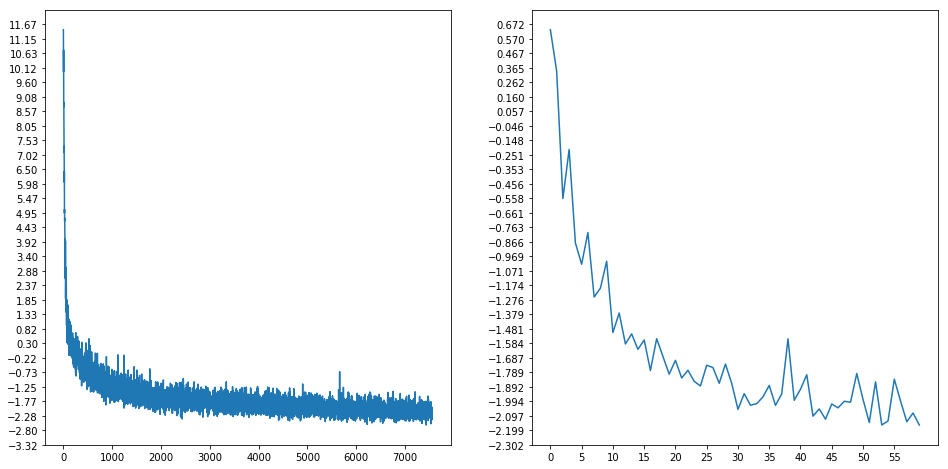

In [65]:
plot(0)

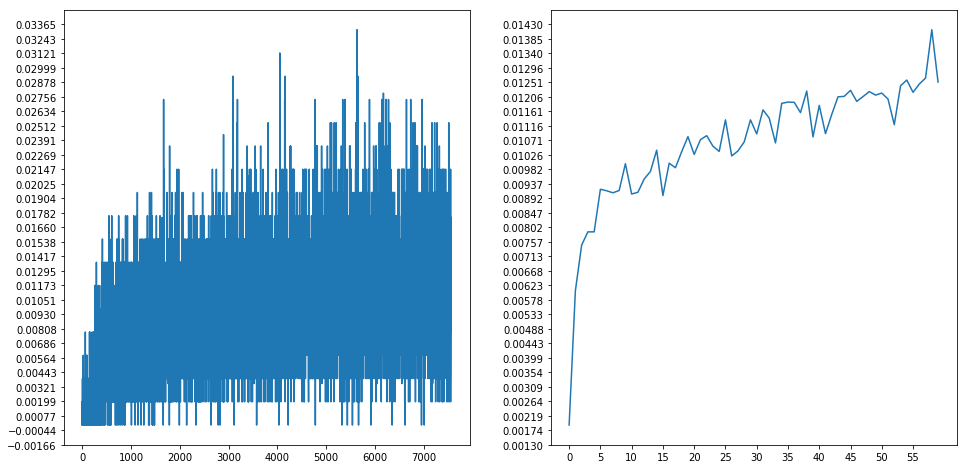

In [66]:
plot(1)

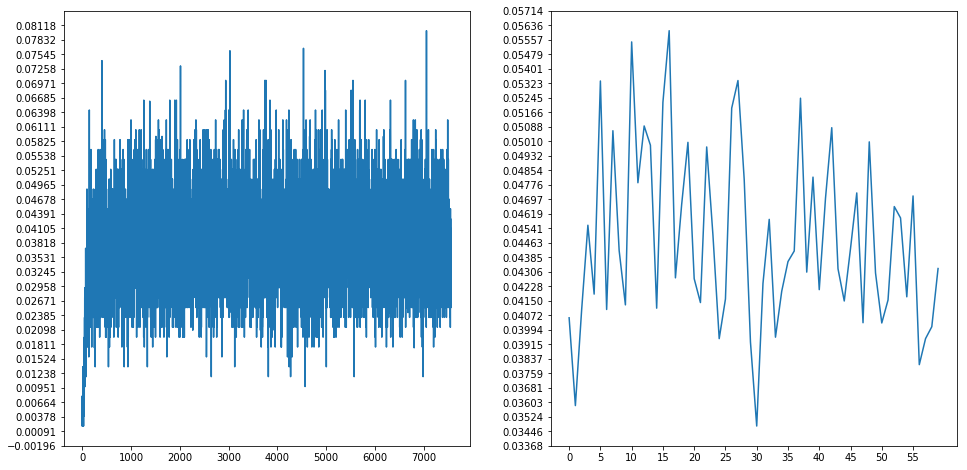

In [67]:
plot(2)

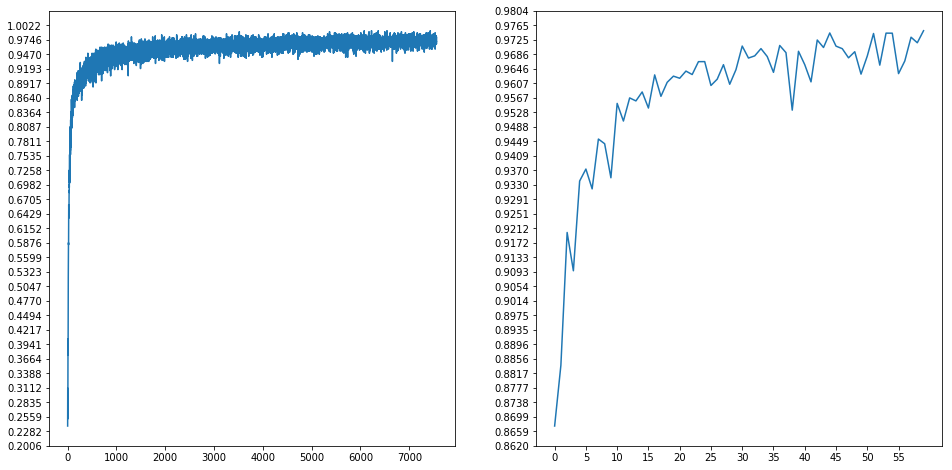

In [68]:
plot(3)

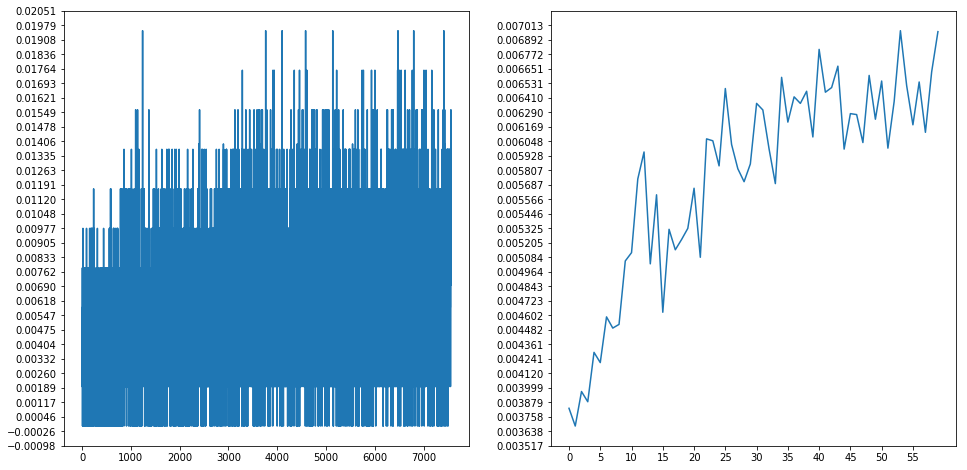

In [69]:
plot(4)

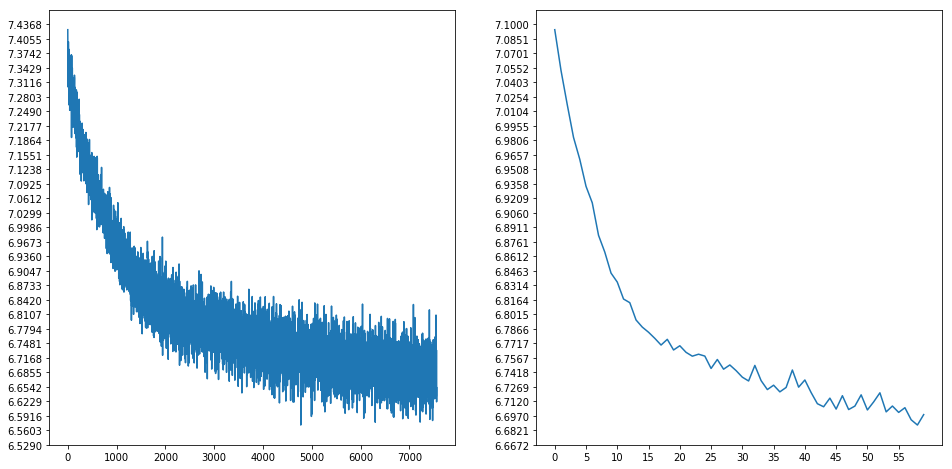

In [70]:
plot(5)

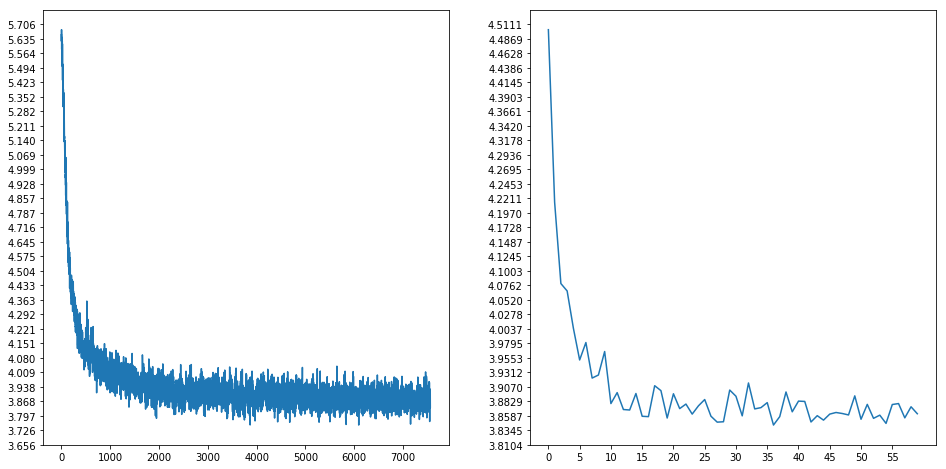

In [71]:
plot(6)

In [72]:
torch.save({'model': model.state_dict(),
           'optimizer': optimizer.state_dict(),
           'metric': (tr_metrics, va_metrics)}, '/kaggle/working/checkpoint.tar')

In [73]:
checkpoint = torch.load('/kaggle/working/checkpoint.tar')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
tr_metrics, va_metrics = checkpoint['metric']

# Submission

In [74]:
# submission = pd.read_csv('../input/best-190819/best_190819.csv')
# id_code = list(submission['id_code'])
# sirna = list(submission['sirna'])
# submission_dict = dict(zip(id_code, sirna))

In [75]:
# with torch.no_grad():
#     model.eval()
#     for (img1, id_code1), (img2, id_code2) in zip(tqdm(te_ds1), te_ds2):
#         assert(id_code1 == id_code2)
#         id_code = id_code1
#         imgs = torch.stack([img1, img2]).cuda()
#         out = model.forward(imgs)
#         pred = torch.argmax(torch.mean(out, dim=0))
#         submission_dict[id_code] = int(pred)
#     model.train()

In [76]:
# submission = pd.DataFrame.from_dict({'id_code' : list(submission_dict.keys()), 'sirna' : list(submission_dict.values())})

In [77]:
# submission.to_csv('submission.csv', index=False, columns=['id_code','sirna'])